In [2]:
import os
import toml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pycurrents.file.binfile_n import BinfileSet
from pycurrents.data import navcalc
from pycurrents.num import interp1 

In [3]:
# give a list of rbin files aoutput catinated array.
def arrayrbins(files):
    mat = list()
    for i in files:
        tmp = BinfileSet(str(i))
        mat.append(tmp.array)
    mat = np.vstack(mat)
    return(mat) 
# generates list of rbin files and calls arrayrbins.
def readrbins(pth, sensor, tag):
    tag = "*" + tag + "*.rbin"
    files = sorted(Path(pth+sensor+"/").glob(tag))
    mat = arrayrbins(files)

    #cols = BinfileSet(str(files[0])).columns
    mat = np.array(mat) #, dtype=cols)
    return(mat)

def carvect(primary, sensor, hdg):
    # interpolate onto the primary pos sensor
    lon = interp1(sensor[:,0], sensor[:,2], primary[:,0])
    lat = interp1(sensor[:,0], sensor[:,3], primary[:,0])

    # I think I should flip this again. i.e. primary - dlon. edit: ehhh not really. 
    dlon = lon - primary[:,2]
    dlat = lat - primary[:,3]

    dxdy = navcalc.diffxy_from_difflonlat(dlon , dlat, primary[:,3])
    dxdy = np.array(dxdy)

    # interpolate dxdy onto heading device because. 
    dx = interp1(primary[:,0], dxdy[0,:], hdg[:,0])
    dy = interp1(primary[:,0], dxdy[1,:], hdg[:,0])
    dxdy = np.array([dx, dy])
    return(dxdy)

# find the location on the ship
def shiplocal(vects, hdg):
    location = [] #np.array([], dtype=[()])
    for i in range(1, len(hdg)):
        tht = hdg[i,1]*(np.pi/180) # to radians
        A = np.array([[np.cos(tht), np.sin(tht)],
                [np.sin(tht)*-1, np.cos(tht)]]).T
        location.append(np.matmul(A, vects[:,i]))
    location = np.vstack(location)
    return(location)

# returns the heading and position device
def devices(path_cruise, cruise_name):
    # from the proc file, get the origin, or main, gps device & the heading device
    if os.path.isfile(path_cruise + 'raw/config/{}_proc.toml'.format(cruise_name)):  # .toml
        proc_cfg = toml.load(path_cruise + 'raw/config/{}_proc.toml'.format(cruise_name))
        pos_origin = (proc_cfg['pos_inst'], proc_cfg['pos_msg'])
        heading_tup = (proc_cfg['hdg_inst'], proc_cfg['hdg_msg'])
    elif os.path.isfile(path_cruise + 'raw/config/{}_proc.py'.format(cruise_name)):  # .py
        proc_cfg = open(path_cruise + 'raw/config/{}_proc.py'.format(cruise_name), 'r')
        for line in proc_cfg:
            if line[:9] == 'pos_inst ':
                pos_inst = line.split('\'')[1]
            if line[:8] == 'pos_msg ':
                pos_msg = line.split('\'')[1]
            if line[:9] == 'hdg_inst ':
                hdg_inst = line.split('\'')[1]
            if line[:8] == 'hdg_msg ':
                hdg_msg = line.split('\'')[1]
        pos_origin = (pos_inst, pos_msg)
        heading_tup = (hdg_inst, hdg_msg)
    else:
        raise NotImplementedError
    return(pos_origin, heading_tup)

In [4]:
path_cruise = "/home/jamie/cruise_data/SE_24_02/"
cruise_name = path_cruise.split('/')[-2]
#cruise_name = "SE_24_02"

In [5]:
# get the prmary position and heading devices
prime_dev, head_dev = devices(path_cruise, cruise_name)

# here is every gps for that cruise that is not the gyro
gps_devices = [x for x in os.listdir(path_cruise+'rbin/')]
gps_devices.remove(prime_dev[0])
gps_devices.remove(head_dev[0])
if 'gyro2' in gps_devices: 
    gps_devices.remove('gyro2')
gps_tups = [(x, 'gps') for x in gps_devices]

In [6]:
# get heading and primary position devices
prime = readrbins(pth = path_cruise + 'rbin/', sensor = prime_dev[0], tag = prime_dev[1])
head  = readrbins(pth = path_cruise + 'rbin/', sensor = head_dev[0], tag = head_dev[1])

In [7]:

# get all gps devices
sensors = list()
for device in gps_tups:
    sensors.append(readrbins(pth = path_cruise + 'rbin/', sensor = device[0], tag = device[1]))

In [8]:
# find the devices positions
pos = list()
dxdy = list()
for device in sensors:
    tmp = carvect(primary = prime, sensor = device, hdg = head)
    dxdy.append(tmp)
    pos.append(shiplocal(vects = tmp, hdg = head))

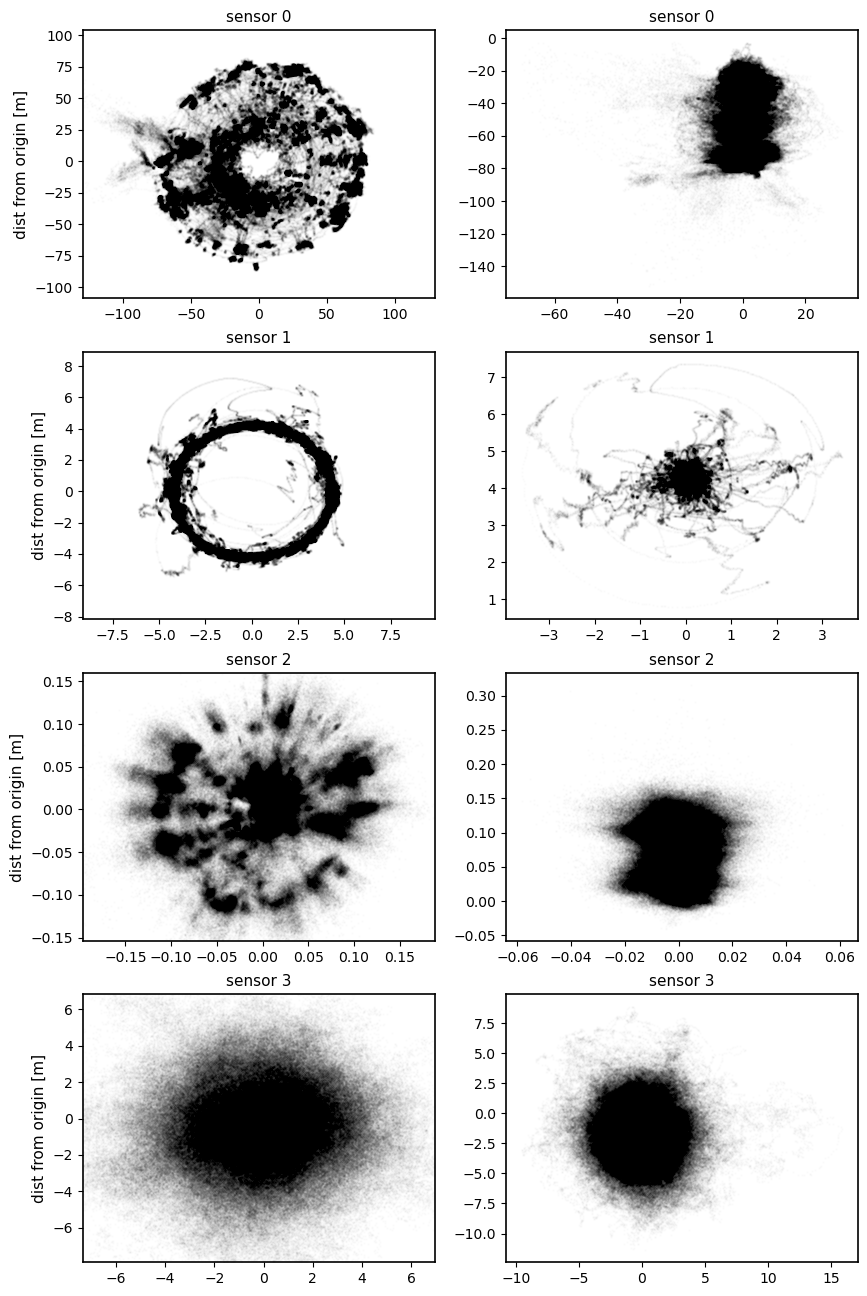

In [9]:
evens = range(2, len(sensors)*2+2, 2)
odds = range(1, len(sensors)*2, 2)
    
fig = plt.figure(figsize=(10, 4*len(sensors)))
for k in range(0, len(sensors)):
    
    diff = dxdy[k]
    local = pos[k]

    ux = np.nanmean(diff[0,:])
    ox = np.nanstd(diff[0,:])
    uy = np.nanmean(diff[1,:])
    oy = np.nanstd(diff[1,:])

    ax = fig.add_subplot(len(sensors), 2, odds[k])
    ax.plot(diff[0,:], diff[1,:], "k.", markersize=1, alpha = 0.02)
    ax.set_title("sensor " + str(k), size = 11)
    ax.set_ylabel("dist from origin [m]", size = 11)
    ax.set_xlim(ux - ox*3, ux + ox*3)
    ax.set_ylim(uy - oy*3, uy + oy*3)
    plt.setp(ax.spines.values(), linewidth = 1.2)

    ux = np.nanmean(local[:,0])
    ox = np.nanstd(local[:,0])
    uy = np.nanmean(local[:, 1])
    oy = np.nanstd(local[:, 1])

    ax = fig.add_subplot(len(sensors), 2, evens[k])
    ax.plot(local[:,0], local[:, 1], "k.", markersize=1, alpha = 0.02)
    ax.set_title("sensor " + str(k), size = 11)
    #ax.set_xlim(ux - ox*12, ux + ox*12)
    #ax.set_ylim(uy - oy*12, uy + oy*12)
    plt.setp(ax.spines.values(), linewidth = 1.2)

In [11]:
# input is matrix of dimensions [x,2] where x is any number.
# columns are the dx dy.   
def xymean(mat):
    ux = np.nanmean(mat[:, 0])
    uy = np.nanmean(mat[:, 1])
    cent = np.array([ux, uy])
    return(cent)

# find the centerpoints.
centers = list()
for position in pos:
    centers.append(xymean(mat = position))
    # set dtype here to gps unit. 

In [307]:
#gyro_files = sorted(Path("/home/jamie/cruise_data/SE_24_02_JH/rbin/gps_gp170_bridge/").glob("*.rbin"))
#cols = BinfileSet(str(gyro_files [0])).columns
#cols

['u_dday', 'dday', 'lon', 'lat', 'quality', 'hdop', 'm_dday']